In [1]:
import temporal_graph
import matplotlib.pyplot as plt

In [6]:
graph = temporal_graph.TemporalGraph()
graph.clean_nodes(True,True,False)

Creating nodes from file ...
done.
creating follower edges from file ...
number of unique followers:2660
done.
assigning truths to nodes ...
mesages dropped due to unforseen circumstancers: 4320
done.
creating time intervall ...
the time intervall of the data goes
from: 2022-02-07 23:31:00 
to: 2022-10-15 21:14:00
done.
cleaning nodes ...
nodes cleaned ...


In [7]:
following_edges_per_node=[]
messages_per_node=[]
counter_following=0
counter_message=0
zero_counter_following=0
zero_counter_message=0
for key in graph.nodes_dict.keys():
    if len(graph.nodes_dict[key].following_edges)!=0:
        following_edges_per_node.append(len(graph.nodes_dict[key].following_edges))
        counter_following+=1
    else:
        zero_counter_following+=1
    if len(graph.nodes_dict[key].truths)!=0:
        messages_per_node.append(len(graph.nodes_dict[key].truths))
        counter_message+=1
    else:
        zero_counter_message+=1

print(f"nodes with no known followers: {zero_counter_following} nodes with followers:{counter_following}")
print(f"nodes with no known messages: {zero_counter_message} with known messages:{counter_message}")

nodes with no known followers: 0 nodes with followers:2256
nodes with no known messages: 0 with known messages:2256


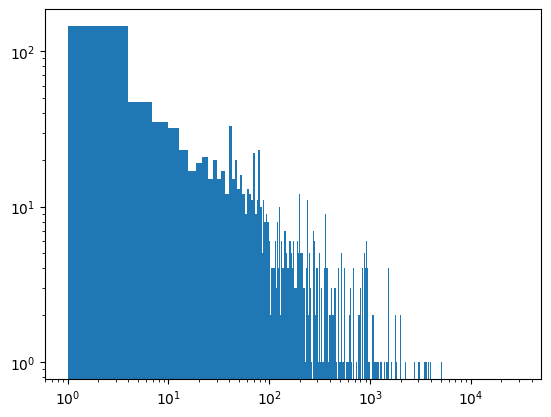

In [12]:

plt.hist(following_edges_per_node,bins=10000)
plt.xscale("log")
plt.yscale("log")


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

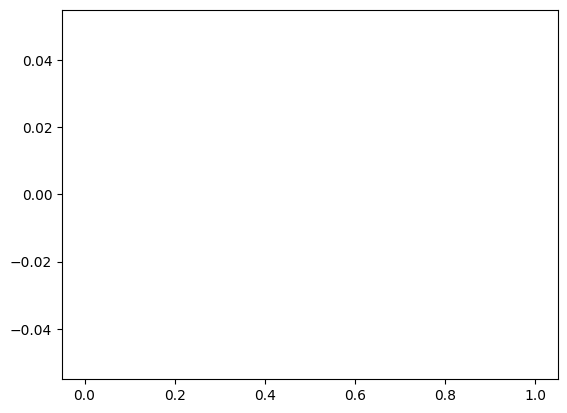

In [5]:
plt.hist(messages_per_node)